## Mission: Réaliser un algorithme de détection de la race d'un chien à partir de sa photo

### Notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres et de data augmentation.

#### On modélisera dans un premier sur 4 races de chiens pour comparer au SIFT du notebook précédent.  
#### Pour une modélisation plus complète, on retiendra ensuite 12 races de chiens (10% du dataset d'origine - 120 races). On confrontera l'accuracy à celle des modèles basés sur du CNN Transfer Learning dans le notebook suivant (pour les mêmes 12 races de chiens).

## Sommaire

- [Importation des librairies](#Importation-des-librairies)
- [4 races de chiens](#4-sans-augmentation)
    - [Construction du Modèle Convolutif](#Construction-du-modèle)
        - Couches convolutives et pooling
        - Aplatissement et couches denses
        - Couche de sortie
        - Compilation
    - [Utilisation de Google Colab](#Google-colab)
        - Utilisation du GPU de Colab pour un temps d'exécution plus rapide
    - [Préparation et Répartition des Données pour 4 races de chiens](#Prétraitement-des-données-4-races)
        - 3 ensembles distincts: entraînement, validation et test
    - [Configuration des Générateurs de Données](#Configuration-des-générateurs-de-données)
        - Utilisation de ImageDataGenerator de Keras. Normalisation, rotation, zoom, retournement horizontal.
    - [Configuration des Paramètres d'Entraînement](#Configuration-des-paramètres-d'entraînement)
        - Calcul des pas par époque et des pas de validation
    - [Suivi du Temps d'Entraînement par Époque](#Suivi-du-Temps-d'Entraînement)
        - Utilisation du callbak de Keras
    - [Entraînement du Modèle et Mesure du Temps d'Exécution Total](#Entraînement-du-modèle-et-mesure-du-temps)
        - Calcul de la métrique accuracy  
        - Matrice de confusion  
- [12 races de chiens - Sans data augmentation](#4-sans-augmentation)
    - Construction du Modèle Convolutif
    - Préparation et Répartition des Données
    - Configuration des Générateurs de Données
    - Configuration des Paramètres d'Entraînement
    - Suivi du Temps d'Entraînement par Époque
    - Entraînement du Modèle et Mesure du Temps d'Exécution Total
- [12 races de chiens - Avec data augmentation](#4-avec-augmentation)
    - Construction du Modèle Convolutif
    - Préparation et Répartition des Données
    - Configuration des Générateurs de Données
    - Configuration des Paramètres d'Entraînement
    - Suivi du Temps d'Entraînement par Époque
    - Entraînement du Modèle et Mesure du Temps d'Exécution Total
- [Vérification de l'absence de data leakage](#Vérification-de-l-absence-de-data-leakage)
    - Comparaison des listes de fichiers dans les dossiers train, validation et test
- [Modification du Modèle Convolutif pour les 12 races de chiens](#Modification-du-modèle-convolutif)
    - Augmentation du nombre de couches et de la taille de la couche dense  
    - Ajout d'un bloc de layers  
    - Modification du taux de dropout  
    - Modification du nombre d'epochs (hyperparamètre d'exécution du modèle)  
    - Overfitting    
    - Modification de l'optimizer (hyperparamètre de compilation du modèle)  
- [Synthèse des différents temps d'entraînement et accuracy pour les modèles étudiés](#Synthèse-des-différents-temps-d-entraînement-et-accuracy-pour-les-modèles-étudiés)


## Importation des libraries<a name="importation-des-librairies"></a>

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
print(os.listdir("/content/cnn_perso_4_races"))
# print(os.listdir("/content/cnn_perso_12_races"))

['train', 'validation', 'test']


In [14]:
shutil.rmtree("/content/cnn_perso_4_races")
# shutil.rmtree("/content/cnn_perso_12_races")

## 4 races de chiens

### Construction du Modèle Convolutif<a name="Construction-du-modèle"></a>

Construction d'un modèle de réseau de neurones convolutif (CNN) pour la classification des races de chiens. Le modèle utilise la bibliothèque Keras et se compose de plusieurs couches convolutives et de pooling, suivies de couches entièrement connectées.

- **Couches Convolutives et Pooling**: Le modèle commence par une couche convolutive avec 64 filtres, suivie d'une couche d'activation ReLU et d'une couche de pooling. Ce motif est répété avec un nombre croissant de filtres (128 et 256), permettant au modèle de capturer des caractéristiques de plus en plus complexes à chaque étape.

- **Aplatissement et Couches Denses**: Après les couches convolutives, les données sont aplaties en un vecteur pour être traitées par des couches entièrement connectées. Une couche dense de 256 neurones avec une activation ReLU est utilisée, suivie d'une couche de Dropout pour réduire le surapprentissage.

- **Couche de Sortie**: La dernière couche dense compte 4 neurones (ce nombre doit être ajusté au nombre de races de chiens à classifier) avec une activation softmax, permettant une classification multi-classes.

- **Compilation**: Le modèle est compilé avec la fonction de perte 'categorical_crossentropy', optimisée par 'adam', et la métrique de performance est la précision ('accuracy').



In [15]:
model = Sequential()

# Première couche convolutive
model.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Répétition du motif pour construire un modèle profond
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de quelques couches supplémentaires
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout des couches entièrement connectées
model.add(Flatten())  # Ceci convertit les cartes de caractéristiques 3D en vecteurs 1D
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# model.add(Dense(<nombre_de_races>))
model.add(Dense(4))
model.add(Activation('softmax'))

# Compilation du modèle
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Utilisation de Google Colab<a name="Google-Colab"></a>

Utilisation du GPU de Colab pour un temps d'exécution plus rapide

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Préparation et répartition des données pour 4 races de chiens<a name="Prétraitement-des-données"></a>

`Pour ne pas avoir un temps d'entrâinement trop long pour le modèle, on limitera le dataset à 10 races de chiens.`  
Script conçu pour préparer et répartir l'ensemble de données d'images de chiens en trois ensembles distincts : entraînement, validation, et test (70%, 15%, 15%). Il utilise le module `os` pour créer des dossiers de structure nécessaire et `shutil` pour copier les images dans les répertoires appropriés.


In [17]:
source_folder = '/content/drive/My Drive/races_chiens_4_224_flou_eq'
# source_folder = 'races_chiens_4_224_flou_eq'

data_folders = ['cnn_perso_4_races/train', 'cnn_perso_4_races/validation', 'cnn_perso_4_races/test']
for folder in data_folders:
    os.makedirs(folder, exist_ok=True)
    for race in os.listdir(source_folder):
        race_path = os.path.join(source_folder, race)
        if os.path.isdir(race_path):  # Vérifiez que c'est bien un dossier
            os.makedirs(os.path.join(folder, race), exist_ok=True)

# Répartition des images
train_ratio = 0.7
validation_ratio = 0.15
# proportion de test implicite, c'est le reste (0.15)

for race_folder in os.listdir(source_folder):
    race_path = os.path.join(source_folder, race_folder)
    if os.path.isdir(race_path):  # Encore une vérification pour s'assurer que c'est un dossier
        all_images = os.listdir(race_path)
        np.random.shuffle(all_images)

        train_split = int(len(all_images) * train_ratio)
        validation_split = int(len(all_images) * (train_ratio + validation_ratio))

        for i, img in enumerate(all_images):
            if i < train_split:
                dest_folder = os.path.join('cnn_perso_4_races/train', race_folder)
            elif i < validation_split:
                dest_folder = os.path.join('cnn_perso_4_races/validation', race_folder)
            else:
                dest_folder = os.path.join('cnn_perso_4_races/test', race_folder)

            shutil.copy(os.path.join(race_path, img), os.path.join(dest_folder, img))


In [18]:
def remove_hidden_files(start_path):
    for root, _, files in os.walk(start_path):
        for file in files:
            if file.startswith('.'):  # Recherche des fichiers cachés
                os.remove(os.path.join(root, file))

# Supprimer les fichiers cachés dans les dossiers de train, validation et test
remove_hidden_files('cnn_perso_4_races/train')
remove_hidden_files('cnn_perso_4_races/validation')
remove_hidden_files('cnn_perso_4_races/test')


### Configuration des Générateurs de Données<a name="Configuration-des-générateurs-de-données"></a>

- **ImageDataGenerator**: Trois instances de `ImageDataGenerator` sont créées. Pour l'ensemble d'entraînement, l'augmentation des données est appliquée pour améliorer la généralisation du modèle. Cela inclut la normalisation (rescale), la rotation (shear_range), le zoom, et le retournement horizontal des images. Pour les ensembles de validation et de test, seule la normalisation est appliquée.

- Contrairement au notebook précédent où l'on a appliqué le SIFT, l'approche de génération de la data augmentation est une création de générateurs qui alimentent directement le modèle pendant l'entraînement. Les images ne sont pas sauvegardées physiquement mais générées à la volée. Elles seraient trop nombreuses et pèseraient trop lourd pour une utilisation dans Google Colab via Google Drive.


In [19]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de test

train_generator = train_datagen.flow_from_directory(
        'cnn_perso_4_races/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        'cnn_perso_4_races/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'cnn_perso_4_races/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


Found 445 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 97 images belonging to 4 classes.


### Configuration des Paramètres d'Entraînement<a name="Configuration-des-paramètres-d'entraînement"></a>

- **Calcul des Pas par Époque et des Pas de Validation**:
    - `steps_per_epoch` est calculé en divisant le nombre total d'images d'entraînement par la taille du lot et en arrondissant au nombre supérieur. Cela détermine le nombre de lots (ou de pas) à traiter lors de chaque époque d'entraînement.
    - `validation_steps` suit un calcul similaire pour l'ensemble de validation.


In [20]:
train_images = 445
validation_images = 96
batch_size = 32

steps_per_epoch = np.ceil(train_images / batch_size)
validation_steps = np.ceil(validation_images / batch_size)


In [21]:
steps_per_epoch

14.0

In [22]:
validation_steps

3.0

In [23]:
print("GPU disponible : ", tf.test.is_gpu_available())
print("Nom du périphérique GPU : ", tf.test.gpu_device_name())


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU disponible :  True
Nom du périphérique GPU :  /device:GPU:0


### Suivi du Temps d'Entraînement par Époque<a name="Suivi-du-Temps-d'Entraînement"></a>

Utilisation du callback de Keras


In [24]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

### Entraînement du Modèle et Mesure du Temps d'Exécution Total<a name="Entraînement-du-modèle-et-mesure-du-temps"></a>

Si les classes étaient fortement déséquilibrées, des métriques comme le rappel (recall), le score F1 ou l'aire sous la courbe ROC (AUC-ROC) pourraient fournir une évaluation nuancée de la performance du modèle, mais on a vu que précédemment que les datasets de races de chiens étaient fournis de manière équilibrée.  
`Les classes étant équilibrées, l'accuracy est ici adpatée comme métrique de performance, d'autant plus que c'est une mesure simple et intuitive: elle représente le pourcentage de prédictions correctes parmi l'ensemble des prédictions faites.`   

In [25]:
start_time = time.time()

model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")


Epoch 1/10
14/14 [==============================] - 18s 595ms/step - loss: 2.8796 - accuracy: 0.2449 - val_loss: 1.3684 - val_accuracy: 0.2604
Epoch 2/10
14/14 [==============================] - 5s 374ms/step - loss: 1.3520 - accuracy: 0.3326 - val_loss: 1.3068 - val_accuracy: 0.3021
Epoch 3/10
14/14 [==============================] - 7s 533ms/step - loss: 1.2792 - accuracy: 0.3865 - val_loss: 1.2427 - val_accuracy: 0.4167
Epoch 4/10
14/14 [==============================] - 5s 376ms/step - loss: 1.2281 - accuracy: 0.4360 - val_loss: 1.2199 - val_accuracy: 0.4479
Epoch 5/10
14/14 [==============================] - 8s 525ms/step - loss: 1.1764 - accuracy: 0.4674 - val_loss: 1.1530 - val_accuracy: 0.4792
Epoch 6/10
14/14 [==============================] - 5s 381ms/step - loss: 1.1044 - accuracy: 0.4876 - val_loss: 1.1686 - val_accuracy: 0.4896
Epoch 7/10
14/14 [==============================] - 5s 380ms/step - loss: 1.0960 - accuracy: 0.5191 - val_loss: 1.1465 - val_accuracy: 0.4479
Epoch

In [26]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_baseline = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_baseline} secondes")

Temps d'entraînement moyen : 7.177567505836487 secondes
Temps d'entraînement total : 71.77567505836487 secondes


In [27]:
resultats = model.evaluate(test_generator)

perte = resultats[0]
accuracy_baseline = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_baseline * 100:.2f}%")

4/4 [==============================] - 1s 315ms/step - loss: 1.3228 - accuracy: 0.4536
Accuracy sur l'ensemble de test: 45.36%


### Matrice de confusion

4/4 [==============================] - 1s 70ms/step


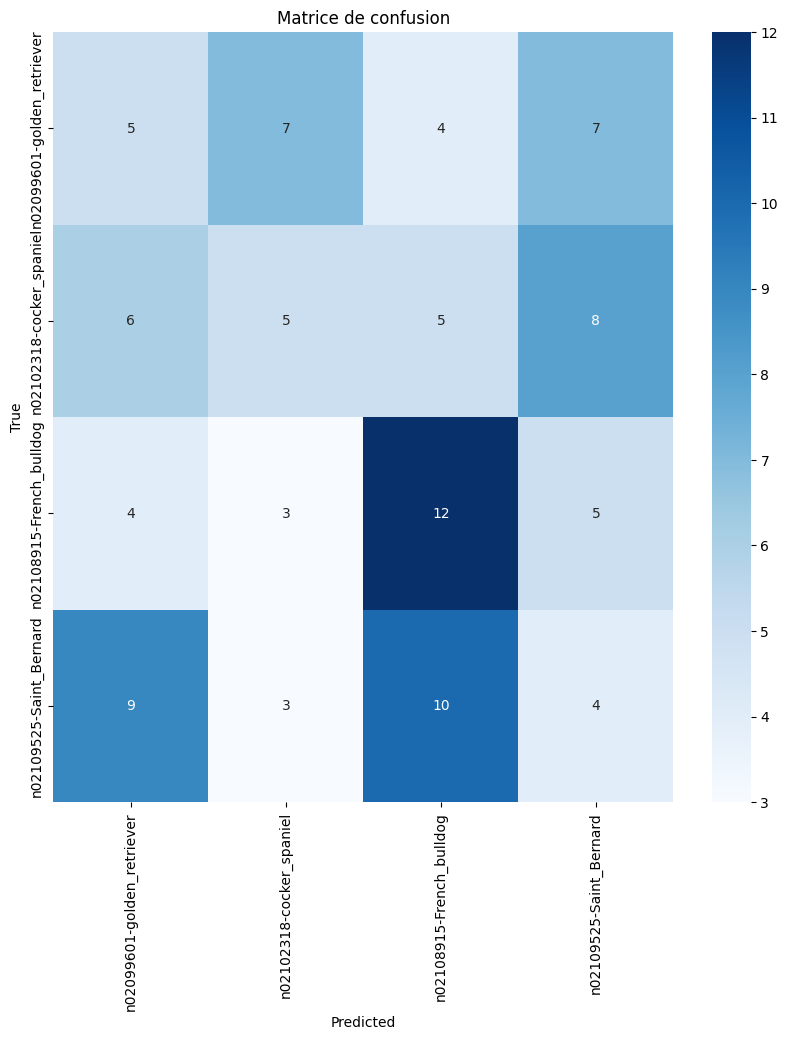

In [28]:
test_images = 97

# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

## 12 races de chiens - Sans data augmentation

### Modélisation, préparation et répartition des données

In [29]:
model_baseline = Sequential()

nombre_races_chiens = 12

# Première couche convolutive
model_baseline.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2, 2)))

# Répétition du motif pour construire un modèle profond
model_baseline.add(Conv2D(128, (3, 3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de quelques couches supplémentaires
model_baseline.add(Conv2D(256, (3, 3)))
model_baseline.add(Activation('relu'))
model_baseline.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout des couches entièrement connectées
model_baseline.add(Flatten())  # Ceci convertit les cartes de caractéristiques 3D en vecteurs 1D
model_baseline.add(Dense(256))
model_baseline.add(Activation('relu'))
model_baseline.add(Dropout(0.5))
# model_baseline.add(Dense(<nombre_de_races>))
model_baseline.add(Dense(nombre_races_chiens))
model_baseline.add(Activation('softmax'))

# Compilation du modèle
model_baseline.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [30]:
source_folder = '/content/drive/My Drive/races_chiens_12_224_flou_eq'

data_folders = ['cnn_perso_12_races/train', 'cnn_perso_12_races/validation', 'cnn_perso_12_races/test']
for folder in data_folders:
    os.makedirs(folder, exist_ok=True)
    for race in os.listdir(source_folder):
        race_path = os.path.join(source_folder, race)
        if os.path.isdir(race_path):  # Vérifiez que c'est bien un dossier
            os.makedirs(os.path.join(folder, race), exist_ok=True)

# Répartition des images
train_ratio = 0.7
validation_ratio = 0.15
# proportion de test implicite, c'est le reste (0.15)

for race_folder in os.listdir(source_folder):
    race_path = os.path.join(source_folder, race_folder)
    if os.path.isdir(race_path):  # Encore une vérification pour s'assurer que c'est un dossier
        all_images = os.listdir(race_path)
        np.random.shuffle(all_images)

        train_split = int(len(all_images) * train_ratio)
        validation_split = int(len(all_images) * (train_ratio + validation_ratio))

        for i, img in enumerate(all_images):
            if i < train_split:
                dest_folder = os.path.join('cnn_perso_12_races/train', race_folder)
            elif i < validation_split:
                dest_folder = os.path.join('cnn_perso_12_races/validation', race_folder)
            else:
                dest_folder = os.path.join('cnn_perso_12_races/test', race_folder)

            shutil.copy(os.path.join(race_path, img), os.path.join(dest_folder, img))


In [31]:
# Supprimer les fichiers cachés dans les dossiers de train, validation et test
remove_hidden_files('cnn_perso_12_races/train')
remove_hidden_files('cnn_perso_12_races/validation')
remove_hidden_files('cnn_perso_12_races/test')


### Configuration des Générateurs de Données<a name="Configuration-des-générateurs-de-données"></a>



In [32]:
train_datagen = ImageDataGenerator(rescale=1./255) # Pas d'augmentation pour les données d'entraînement
val_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de test

train_generator = train_datagen.flow_from_directory(
        'cnn_perso_12_races/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        'cnn_perso_12_races/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'cnn_perso_12_races/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


Found 1370 images belonging to 12 classes.
Found 294 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


### Configuration des Paramètres d'Entraînement<a name="Configuration-des-paramètres-d'entraînement"></a>

- **Calcul des Pas par Époque et des Pas de Validation**:
    - `steps_per_epoch` est calculé en divisant le nombre total d'images d'entraînement par la taille du lot et en arrondissant au nombre supérieur. Cela détermine le nombre de lots (ou de pas) à traiter lors de chaque époque d'entraînement.
    - `validation_steps` suit un calcul similaire pour l'ensemble de validation.


In [33]:
train_images = 1370
validation_images = 294
batch_size = 32

steps_per_epoch = np.ceil(train_images / batch_size)
validation_steps = np.ceil(validation_images / batch_size)


In [34]:
steps_per_epoch

43.0

In [35]:
validation_steps

10.0

In [36]:
print("GPU disponible : ", tf.test.is_gpu_available())
print("Nom du périphérique GPU : ", tf.test.gpu_device_name())


GPU disponible :  True
Nom du périphérique GPU :  /device:GPU:0


### Vérification de l'absence de data leakage

Comparaison des listes de fichiers dans les dossiers train, validation et test

In [37]:
def get_file_paths(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                file_paths.append(os.path.join(root, file))
    return file_paths

# listes des fichiers dans chaque jeu de données
train_files = get_file_paths('cnn_perso_12_races/train')
val_files = get_file_paths('cnn_perso_12_races/validation')
test_files = get_file_paths('cnn_perso_12_races/test')


In [38]:
def check_data_leakage(set1, set2):
    return set(set1).intersection(set(set2))

leakage_between_train_val = check_data_leakage(train_files, val_files)
leakage_between_train_test = check_data_leakage(train_files, test_files)
leakage_between_val_test = check_data_leakage(val_files, test_files)

# On vérifie s'il y a des éléments communs
print("Fuite entre entraînement et validation:", leakage_between_train_val)
print("Fuite entre entraînement et test:", leakage_between_train_test)
print("Fuite entre validation et test:", leakage_between_val_test)


Fuite entre entraînement et validation: set()
Fuite entre entraînement et test: set()
Fuite entre validation et test: set()


### Suivi du Temps d'Entraînement par Époque<a name="Suivi-du-Temps-d'Entraînement"></a>

Utilisation du callback de Keras


In [39]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

### Entraînement du Modèle et Mesure du Temps d'Exécution Total<a name="Entraînement-du-modèle-et-mesure-du-temps"></a>

Si les classes étaient fortement déséquilibrées, des métriques comme le rappel (recall), le score F1 ou l'aire sous la courbe ROC (AUC-ROC) pourraient fournir une évaluation nuancée de la performance du modèle, mais on a vu que précédemment que les datasets de races de chiens étaient fournis de manière équilibrée.  
`Les classes étant équilibrées, l'accuracy est ici adpatée comme métrique de performance, d'autant plus que c'est une mesure simple et intuitive: elle représente le pourcentage de prédictions correctes parmi l'ensemble des prédictions faites.`   

In [40]:
start_time = time.time()

model_baseline.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")


Epoch 1/10
 6/43 [===>..........................] - ETA: 4s - loss: 4.6124 - accuracy: 0.0573

43/43 [==============================] - 10s 199ms/step - loss: 2.7869 - accuracy: 0.0839 - val_loss: 2.4842 - val_accuracy: 0.1088
Epoch 2/10
43/43 [==============================] - 5s 120ms/step - loss: 2.4864 - accuracy: 0.1073 - val_loss: 2.4836 - val_accuracy: 0.0952
Epoch 3/10
43/43 [==============================] - 5s 123ms/step - loss: 2.4822 - accuracy: 0.0956 - val_loss: 2.4907 - val_accuracy: 0.0986
Epoch 4/10
43/43 [==============================] - 5s 117ms/step - loss: 2.4625 - accuracy: 0.1314 - val_loss: 2.4385 - val_accuracy: 0.1395
Epoch 5/10
43/43 [==============================] - 6s 139ms/step - loss: 2.2804 - accuracy: 0.2277 - val_loss: 2.4277 - val_accuracy: 0.1497
Epoch 6/10
43/43 [==============================] - 5s 118ms/step - loss: 1.8966 - accuracy: 0.3628 - val_loss: 2.5721 - val_accuracy: 0.1463
Epoch 7/10
43/43 [==============================] - 5s 117ms/step - loss: 1.1709 - accuracy: 0.6146 - val_loss: 3.3235 - val_accuracy: 0.1599
Epoch 8/10
43/43

In [41]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_baseline = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_baseline} secondes")

Temps d'entraînement moyen : 5.79091637134552 secondes
Temps d'entraînement total : 57.9091637134552 secondes


In [42]:
resultats = model_baseline.evaluate(test_generator)

perte = resultats[0]
accuracy_baseline = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_baseline * 100:.2f}%")

10/10 [==============================] - 1s 124ms/step - loss: 4.6762 - accuracy: 0.1867
Accuracy sur l'ensemble de test: 18.67%


### Matrice de confusion

10/10 [==============================] - 1s 56ms/step


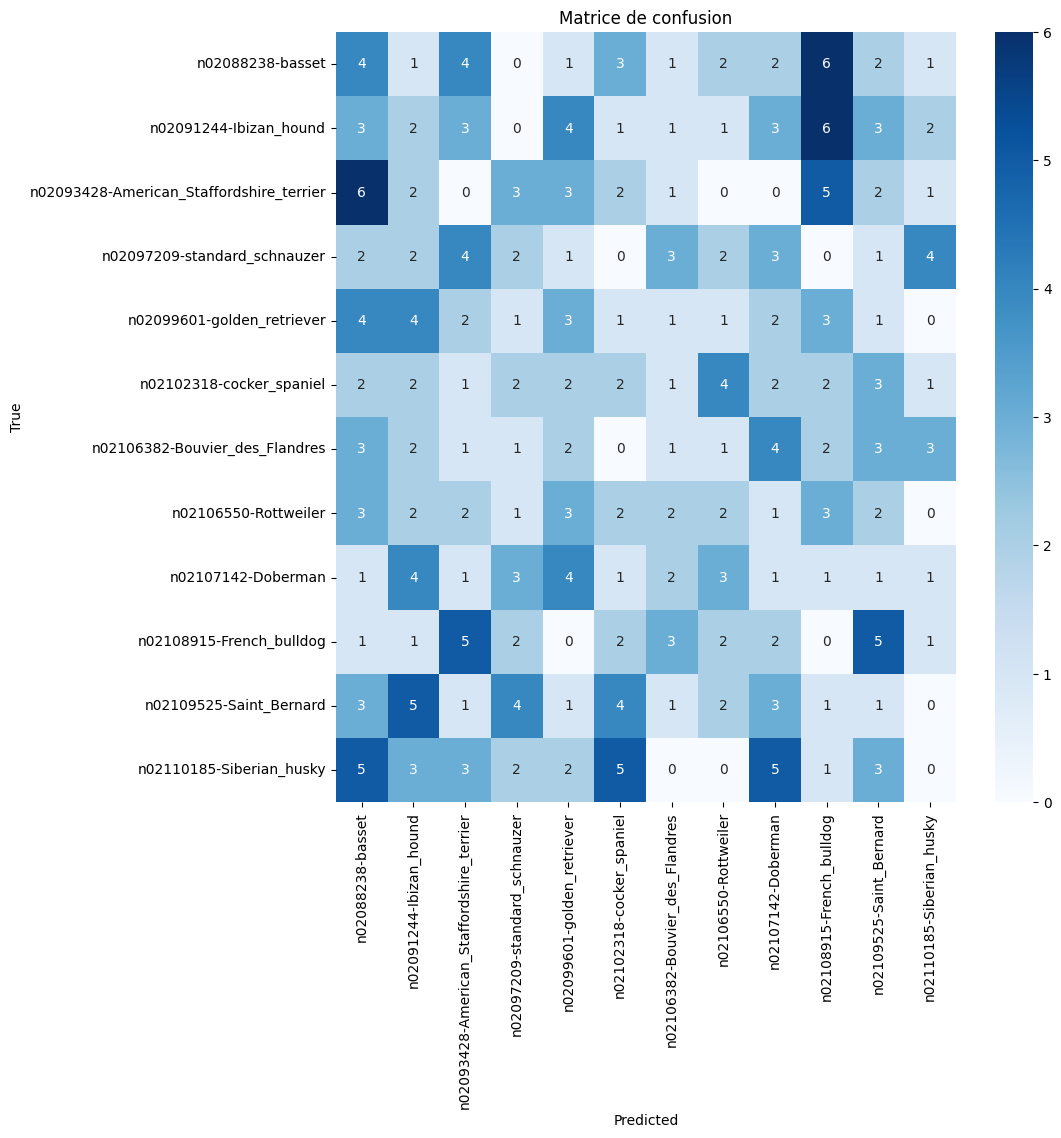

In [43]:
test_images = 300

# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model_baseline.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

## 12 races de chiens - Avec data augmentation

### Modélisation, préparation et répartition des données

In [44]:
shutil.rmtree("/content/cnn_perso_12_races")

In [45]:
model_data_aug = Sequential()

nombre_races_chiens = 12

# Première couche convolutive
model_data_aug.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_data_aug.add(Activation('relu'))
model_data_aug.add(MaxPooling2D(pool_size=(2, 2)))

# Répétition du motif pour construire un modèle profond
model_data_aug.add(Conv2D(128, (3, 3)))
model_data_aug.add(Activation('relu'))
model_data_aug.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de quelques couches supplémentaires
model_data_aug.add(Conv2D(256, (3, 3)))
model_data_aug.add(Activation('relu'))
model_data_aug.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout des couches entièrement connectées
model_data_aug.add(Flatten())  # Ceci convertit les cartes de caractéristiques 3D en vecteurs 1D
model_data_aug.add(Dense(256))
model_data_aug.add(Activation('relu'))
model_data_aug.add(Dropout(0.5))
# model_data_aug.add(Dense(<nombre_de_races>))
model_data_aug.add(Dense(nombre_races_chiens))
model_data_aug.add(Activation('softmax'))

# Compilation du modèle
model_data_aug.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [46]:
source_folder = '/content/drive/My Drive/races_chiens_12_224_flou_eq'

data_folders = ['cnn_perso_12_races/train', 'cnn_perso_12_races/validation', 'cnn_perso_12_races/test']
for folder in data_folders:
    os.makedirs(folder, exist_ok=True)
    for race in os.listdir(source_folder):
        race_path = os.path.join(source_folder, race)
        if os.path.isdir(race_path):  # Vérifiez que c'est bien un dossier
            os.makedirs(os.path.join(folder, race), exist_ok=True)

# Répartition des images
train_ratio = 0.7
validation_ratio = 0.15
# proportion de test implicite, c'est le reste (0.15)

for race_folder in os.listdir(source_folder):
    race_path = os.path.join(source_folder, race_folder)
    if os.path.isdir(race_path):  # Encore une vérification pour s'assurer que c'est un dossier
        all_images = os.listdir(race_path)
        np.random.shuffle(all_images)

        train_split = int(len(all_images) * train_ratio)
        validation_split = int(len(all_images) * (train_ratio + validation_ratio))

        for i, img in enumerate(all_images):
            if i < train_split:
                dest_folder = os.path.join('cnn_perso_12_races/train', race_folder)
            elif i < validation_split:
                dest_folder = os.path.join('cnn_perso_12_races/validation', race_folder)
            else:
                dest_folder = os.path.join('cnn_perso_12_races/test', race_folder)

            shutil.copy(os.path.join(race_path, img), os.path.join(dest_folder, img))


In [47]:
# Supprimer les fichiers cachés dans les dossiers de train, validation et test
remove_hidden_files('cnn_perso_12_races/train')
remove_hidden_files('cnn_perso_12_races/validation')
remove_hidden_files('cnn_perso_12_races/test')


### Configuration des Générateurs de Données<a name="Configuration-des-générateurs-de-données"></a>



In [48]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de validation
test_datagen = ImageDataGenerator(rescale=1./255)  # Pas d'augmentation pour les données de test

train_generator = train_datagen.flow_from_directory(
        'cnn_perso_12_races/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        'cnn_perso_12_races/validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        'cnn_perso_12_races/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


Found 1370 images belonging to 12 classes.
Found 294 images belonging to 12 classes.
Found 300 images belonging to 12 classes.


### Configuration des Paramètres d'Entraînement<a name="Configuration-des-paramètres-d'entraînement"></a>

In [49]:
train_images = 1370
validation_images = 294
batch_size = 32

steps_per_epoch = np.ceil(train_images / batch_size)
validation_steps = np.ceil(validation_images / batch_size)


In [50]:
steps_per_epoch

43.0

In [51]:
validation_steps

10.0

In [52]:
print("GPU disponible : ", tf.test.is_gpu_available())
print("Nom du périphérique GPU : ", tf.test.gpu_device_name())


GPU disponible :  True
Nom du périphérique GPU :  /device:GPU:0


### Suivi du Temps d'Entraînement par Époque<a name="Suivi-du-Temps-d'Entraînement"></a>

Utilisation du callback de Keras


In [53]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

### Entraînement du Modèle et Mesure du Temps d'Exécution Total<a name="Entraînement-du-modèle-et-mesure-du-temps"></a>

In [54]:
start_time = time.time()

model_data_aug.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")


Epoch 1/10
43/43 [==============================] - 21s 441ms/step - loss: 2.7236 - accuracy: 0.0956 - val_loss: 2.4841 - val_accuracy: 0.1020
Epoch 2/10
43/43 [==============================] - 19s 428ms/step - loss: 2.4859 - accuracy: 0.1007 - val_loss: 2.4822 - val_accuracy: 0.0952
Epoch 3/10
43/43 [==============================] - 18s 419ms/step - loss: 2.4501 - accuracy: 0.1292 - val_loss: 2.3957 - val_accuracy: 0.1361
Epoch 4/10
43/43 [==============================] - 20s 468ms/step - loss: 2.3900 - accuracy: 0.1533 - val_loss: 2.3746 - val_accuracy: 0.1735
Epoch 5/10
43/43 [==============================] - 18s 427ms/step - loss: 2.3416 - accuracy: 0.1847 - val_loss: 2.3519 - val_accuracy: 0.1803
Epoch 6/10
43/43 [==============================] - 18s 417ms/step - loss: 2.3206 - accuracy: 0.1891 - val_loss: 2.3363 - val_accuracy: 0.2245
Epoch 7/10
43/43 [==============================] - 18s 419ms/step - loss: 2.2889 - accuracy: 0.2117 - val_loss: 2.3165 - val_accuracy: 0.2245

In [55]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_data_aug = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_data_aug} secondes")

Temps d'entraînement moyen : 18.766565990447997 secondes
Temps d'entraînement total : 187.66565990447998 secondes


In [56]:
resultats = model_data_aug.evaluate(test_generator)

perte = resultats[0]
accuracy_data_aug = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_data_aug * 100:.2f}%")

10/10 [==============================] - 1s 61ms/step - loss: 2.2294 - accuracy: 0.2267
Accuracy sur l'ensemble de test: 22.67%


### Matrice de confusion

10/10 [==============================] - 1s 78ms/step


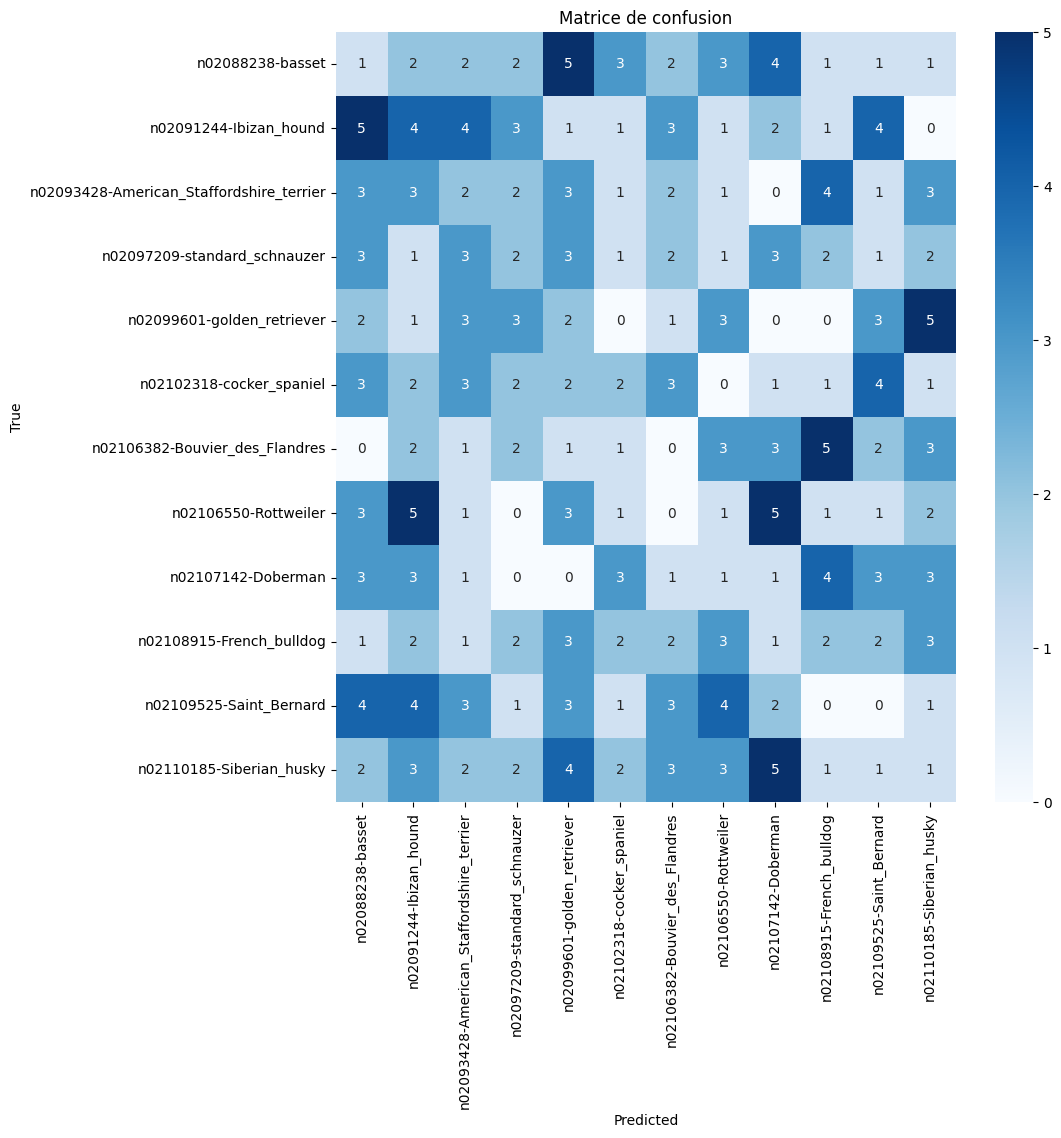

In [57]:
test_images = 300

# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model_baseline.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

## Vérification de l'absence de data leakage

Comparaison des listes de fichiers dans les dossiers train, validation et test

In [58]:
def get_file_paths(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                file_paths.append(os.path.join(root, file))
    return file_paths

# listes des fichiers dans chaque jeu de données
train_files = get_file_paths('cnn_perso_12_races/train')
val_files = get_file_paths('cnn_perso_12_races/validation')
test_files = get_file_paths('cnn_perso_12_races/test')


In [59]:
def check_data_leakage(set1, set2):
    return set(set1).intersection(set(set2))

leakage_between_train_val = check_data_leakage(train_files, val_files)
leakage_between_train_test = check_data_leakage(train_files, test_files)
leakage_between_val_test = check_data_leakage(val_files, test_files)

# On vérifie s'il y a des éléments communs
print("Fuite entre entraînement et validation:", leakage_between_train_val)
print("Fuite entre entraînement et test:", leakage_between_train_test)
print("Fuite entre validation et test:", leakage_between_val_test)


Fuite entre entraînement et validation: set()
Fuite entre entraînement et test: set()
Fuite entre validation et test: set()


## Modification du Modèle Convolutif<a name="Modification-du-modèle-convolutif"></a>

### Augmentation du nombre de couches et de la taille de la couche dense

Les changements incluent l'augmentation du nombre de filtres dans une des couches convolutives et l'augmentation de la taille de la couche dense. Ces modifications visent à améliorer la capacité du modèle à apprendre des caractéristiques plus complexes.

- **Couches Convolutives et Pooling**:
    - Les deux premières couches convolutives et de pooling restent inchangées avec 64 et 128 filtres, respectivement.
    - Une troisième couche convolutive est ajoutée avec 512 filtres, nettement plus que dans les couches précédentes. Cela permet au modèle de détecter un plus large éventail de caractéristiques.

- **Couche Dense et Dropout**:
    - Après l'aplatissement des données, une couche dense avec 512 neurones est utilisée, augmentée par rapport à la version précédente du modèle. Cela donne au réseau une plus grande capacité de traitement et peut aider à mieux capturer les relations complexes dans les données.
    - Une couche de Dropout avec un taux de 0.5 est conservée pour réduire le surapprentissage.


In [60]:
model_layer = Sequential()

model_layer.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_layer.add(Activation('relu'))
model_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_layer.add(Conv2D(128, (3, 3)))
model_layer.add(Activation('relu'))
model_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_layer.add(Conv2D(512, (3, 3)))  # Augmentation du nombre de filtres
model_layer.add(Activation('relu'))
model_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_layer.add(Flatten())
model_layer.add(Dense(512))  # Augmentation de la taille de la couche dense
model_layer.add(Activation('relu'))
model_layer.add(Dropout(0.5))
model_layer.add(Dense(nombre_races_chiens, activation='softmax'))

model_layer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [61]:
start_time = time.time()

model_layer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")

Epoch 1/10
43/43 [==============================] - 24s 453ms/step - loss: 3.3963 - accuracy: 0.0854 - val_loss: 2.4839 - val_accuracy: 0.0884
Epoch 2/10
43/43 [==============================] - 19s 437ms/step - loss: 2.4573 - accuracy: 0.1204 - val_loss: 2.4173 - val_accuracy: 0.1327
Epoch 3/10
43/43 [==============================] - 19s 439ms/step - loss: 2.3875 - accuracy: 0.1474 - val_loss: 2.3559 - val_accuracy: 0.1837
Epoch 4/10
43/43 [==============================] - 21s 484ms/step - loss: 2.3295 - accuracy: 0.1766 - val_loss: 2.3396 - val_accuracy: 0.1871
Epoch 5/10
43/43 [==============================] - 19s 439ms/step - loss: 2.3092 - accuracy: 0.1956 - val_loss: 2.3327 - val_accuracy: 0.1735
Epoch 6/10
43/43 [==============================] - 19s 436ms/step - loss: 2.2611 - accuracy: 0.2168 - val_loss: 2.2694 - val_accuracy: 0.2211
Epoch 7/10
43/43 [==============================] - 21s 494ms/step - loss: 2.2209 - accuracy: 0.2321 - val_loss: 2.2901 - val_accuracy: 0.2041

In [62]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_layer = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_layer} secondes")

Temps d'entraînement moyen : 20.021115040779115 secondes
Temps d'entraînement total : 200.21115040779114 secondes


In [63]:
resultats = model_layer.evaluate(test_generator)

perte = resultats[0]
accuracy_layer = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_layer * 100:.2f}%")

10/10 [==============================] - 1s 96ms/step - loss: 2.1445 - accuracy: 0.2300
Accuracy sur l'ensemble de test: 23.00%


10/10 [==============================] - 1s 54ms/step


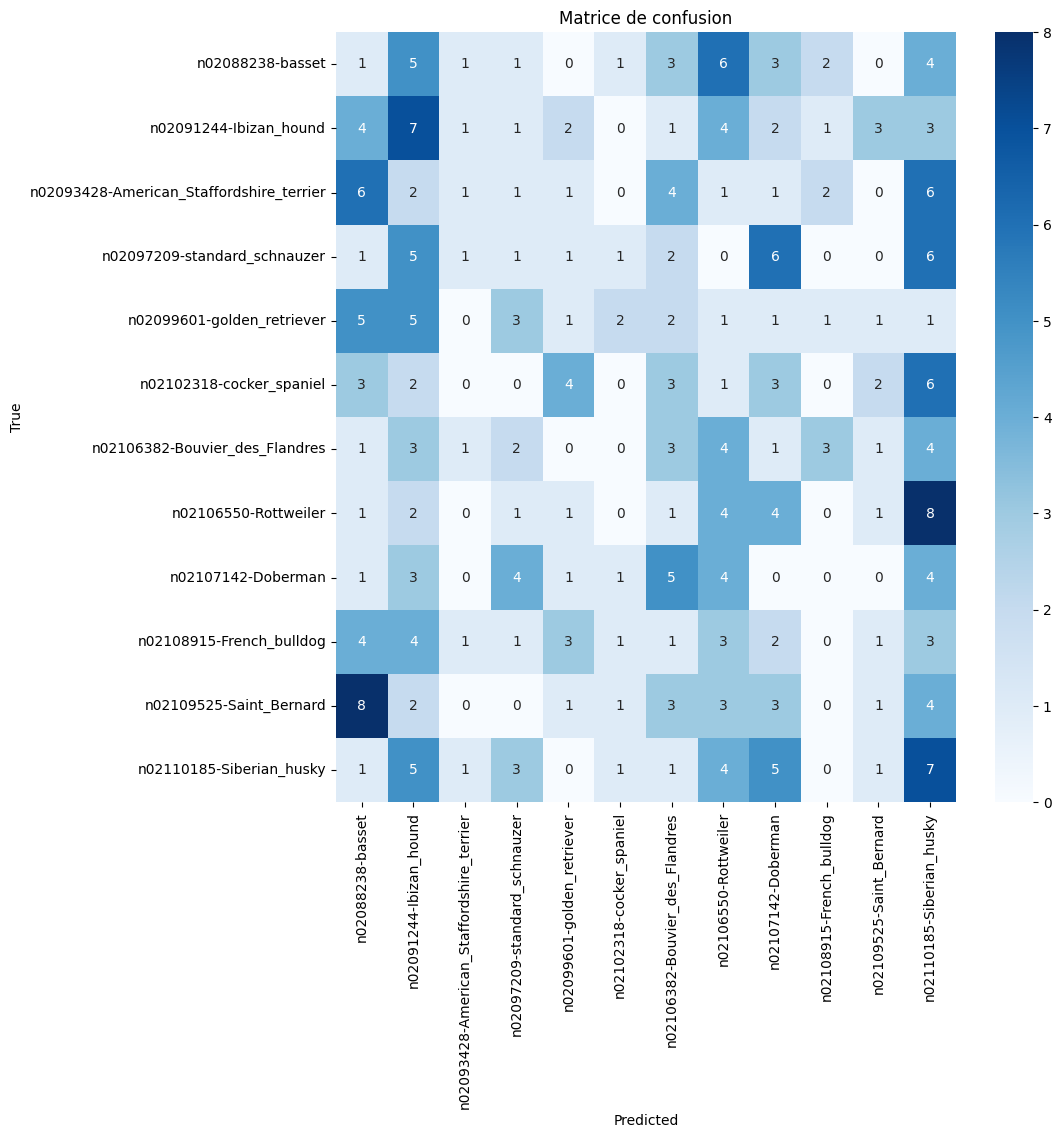

In [64]:
# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model_layer.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

### Ajout d'un bloc de layers supplémentaire

In [65]:
model_bloc_layer = Sequential()

model_bloc_layer.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_bloc_layer.add(Activation('relu'))
model_bloc_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_bloc_layer.add(Conv2D(128, (3, 3)))
model_bloc_layer.add(Activation('relu'))
model_bloc_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_bloc_layer.add(Conv2D(256, (3, 3)))
model_bloc_layer.add(Activation('relu'))
model_bloc_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_bloc_layer.add(Conv2D(256, (3, 3)))  # Ajout d'un bloc supplémentaire
model_bloc_layer.add(Activation('relu'))
model_bloc_layer.add(MaxPooling2D(pool_size=(2, 2)))

model_bloc_layer.add(Flatten())
model_bloc_layer.add(Dense(256))
model_bloc_layer.add(Activation('relu'))
model_bloc_layer.add(Dropout(0.5))
model_bloc_layer.add(Dense(nombre_races_chiens, activation='softmax'))

model_bloc_layer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
start_time = time.time()

model_bloc_layer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")

Epoch 1/10
43/43 [==============================] - 21s 427ms/step - loss: 2.5211 - accuracy: 0.0883 - val_loss: 2.4809 - val_accuracy: 0.0952
Epoch 2/10
43/43 [==============================] - 19s 440ms/step - loss: 2.4734 - accuracy: 0.1088 - val_loss: 2.4321 - val_accuracy: 0.1735
Epoch 3/10
43/43 [==============================] - 18s 420ms/step - loss: 2.3842 - accuracy: 0.1336 - val_loss: 2.3202 - val_accuracy: 0.2041
Epoch 4/10
43/43 [==============================] - 18s 417ms/step - loss: 2.3101 - accuracy: 0.1839 - val_loss: 2.2884 - val_accuracy: 0.2075
Epoch 5/10
43/43 [==============================] - 18s 422ms/step - loss: 2.2693 - accuracy: 0.2036 - val_loss: 2.2435 - val_accuracy: 0.2347
Epoch 6/10
43/43 [==============================] - 18s 426ms/step - loss: 2.1923 - accuracy: 0.2401 - val_loss: 2.2307 - val_accuracy: 0.2313
Epoch 7/10
43/43 [==============================] - 20s 453ms/step - loss: 2.1575 - accuracy: 0.2518 - val_loss: 2.1941 - val_accuracy: 0.2415

In [67]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_bloc_layer = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_bloc_layer} secondes")


Temps d'entraînement moyen : 18.882703566551207 secondes
Temps d'entraînement total : 188.82703566551208 secondes


In [68]:
resultats = model_bloc_layer.evaluate(test_generator)

perte = resultats[0]
accuracy_bloc_layer = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_bloc_layer * 100:.2f}%")

10/10 [==============================] - 1s 60ms/step - loss: 1.9512 - accuracy: 0.3167
Accuracy sur l'ensemble de test: 31.67%


10/10 [==============================] - 1s 48ms/step


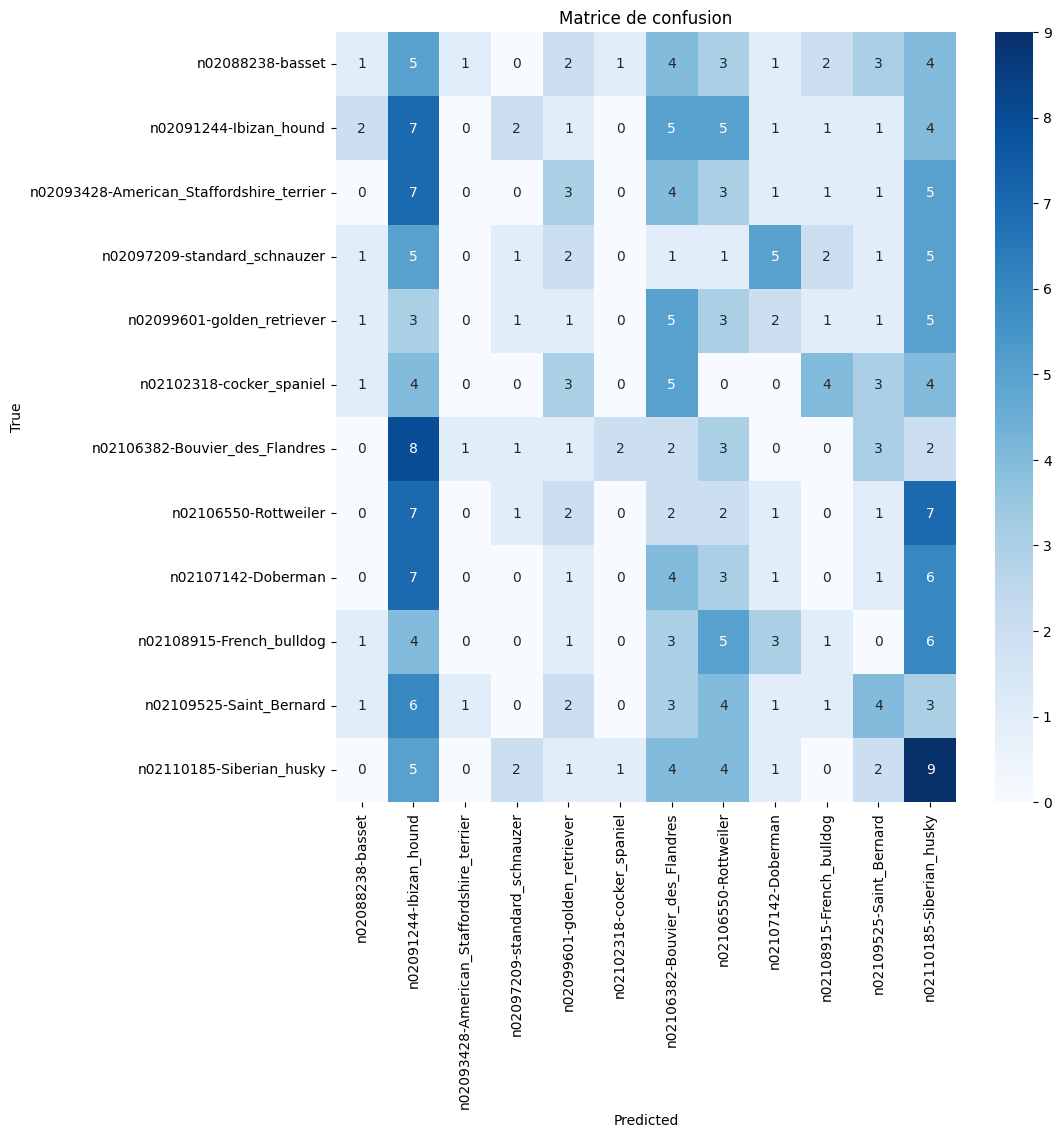

In [69]:
# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model_bloc_layer.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

### Modification du taux de dropout

In [70]:
model_dropout = Sequential()

model_dropout.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_dropout.add(Activation('relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_dropout.add(Conv2D(128, (3, 3)))
model_dropout.add(Activation('relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_dropout.add(Conv2D(256, (3, 3)))
model_dropout.add(Activation('relu'))
model_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_dropout.add(Flatten())
model_dropout.add(Dense(256))
model_dropout.add(Activation('relu'))
model_dropout.add(Dropout(0.3))  # Modification du taux de dropout
model_dropout.add(Dense(nombre_races_chiens, activation='softmax'))

model_dropout.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [71]:
start_time = time.time()

model_dropout.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")

Epoch 1/10
43/43 [==============================] - 19s 410ms/step - loss: 2.7342 - accuracy: 0.1029 - val_loss: 2.4844 - val_accuracy: 0.0816
Epoch 2/10
43/43 [==============================] - 20s 456ms/step - loss: 2.4845 - accuracy: 0.0876 - val_loss: 2.4744 - val_accuracy: 0.0986
Epoch 3/10
43/43 [==============================] - 18s 416ms/step - loss: 2.4740 - accuracy: 0.1022 - val_loss: 2.4828 - val_accuracy: 0.0952
Epoch 4/10
43/43 [==============================] - 18s 417ms/step - loss: 2.4836 - accuracy: 0.0949 - val_loss: 2.4828 - val_accuracy: 0.0952
Epoch 5/10
43/43 [==============================] - 18s 419ms/step - loss: 2.4835 - accuracy: 0.0949 - val_loss: 2.4824 - val_accuracy: 0.0952
Epoch 6/10
43/43 [==============================] - 20s 456ms/step - loss: 2.4828 - accuracy: 0.0949 - val_loss: 2.4821 - val_accuracy: 0.0952
Epoch 7/10
43/43 [==============================] - 19s 429ms/step - loss: 2.4827 - accuracy: 0.0920 - val_loss: 2.4818 - val_accuracy: 0.0952

In [72]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_dropout = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_dropout} secondes")

Temps d'entraînement moyen : 18.73488211631775 secondes
Temps d'entraînement total : 187.3488211631775 secondes


In [73]:
resultats = model_dropout.evaluate(test_generator)

perte = resultats[0]
accuracy_dropout = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_dropout * 100:.2f}%")

10/10 [==============================] - 1s 52ms/step - loss: 2.4816 - accuracy: 0.0967
Accuracy sur l'ensemble de test: 9.67%


10/10 [==============================] - 1s 56ms/step


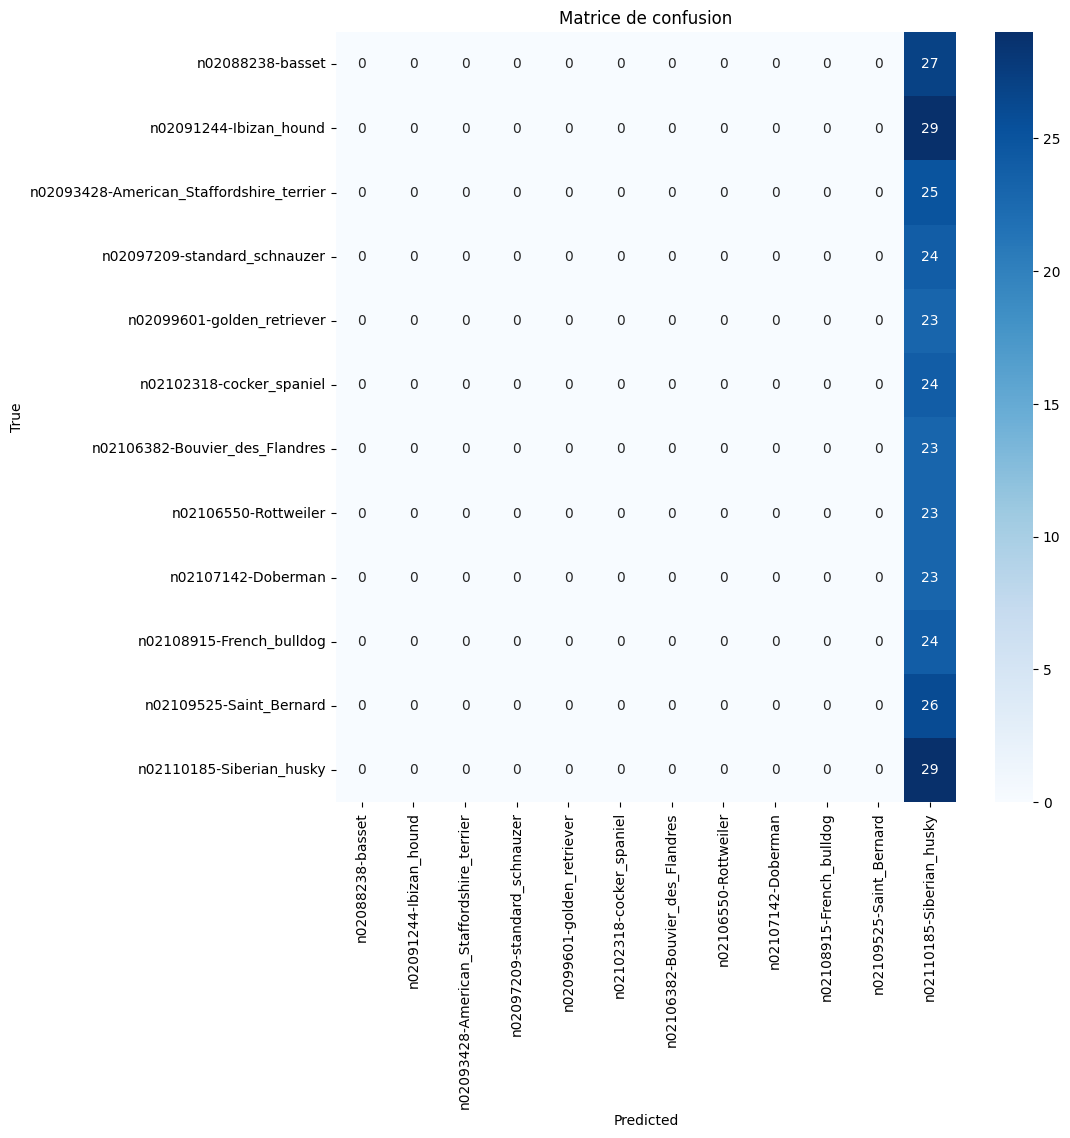

In [74]:
# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model_dropout.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

### Modification du nombre d'epochs (hyperparamètre d'exécution du modèle)

In [75]:
model_epoch = Sequential()

# Première couche convolutive
model_epoch.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_epoch.add(Activation('relu'))
model_epoch.add(MaxPooling2D(pool_size=(2, 2)))

# Répétition du motif pour construire un modèle profond
model_epoch.add(Conv2D(128, (3, 3)))
model_epoch.add(Activation('relu'))
model_epoch.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de quelques couches supplémentaires
model_epoch.add(Conv2D(256, (3, 3)))
model_epoch.add(Activation('relu'))
model_epoch.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout des couches entièrement connectées
model_epoch.add(Flatten())  # Ceci convertit les cartes de caractéristiques 3D en vecteurs 1D
model_epoch.add(Dense(256))
model_epoch.add(Activation('relu'))
model_epoch.add(Dropout(0.5))
model_epoch.add(Dense(nombre_races_chiens))
model_epoch.add(Activation('softmax'))

# Compilation du modèle
model_epoch.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

On essaie en augmentant le nombre d'epochs à 20 au lieu de 10.

In [76]:
start_time = time.time()

model_epoch.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")

Epoch 1/20
43/43 [==============================] - 19s 412ms/step - loss: 2.7298 - accuracy: 0.0796 - val_loss: 2.4808 - val_accuracy: 0.1020
Epoch 2/20
43/43 [==============================] - 18s 424ms/step - loss: 2.4652 - accuracy: 0.1153 - val_loss: 2.4115 - val_accuracy: 0.1293
Epoch 3/20
43/43 [==============================] - 18s 425ms/step - loss: 2.3542 - accuracy: 0.1891 - val_loss: 2.3725 - val_accuracy: 0.1735
Epoch 4/20
43/43 [==============================] - 18s 412ms/step - loss: 2.2582 - accuracy: 0.2285 - val_loss: 2.2634 - val_accuracy: 0.2245
Epoch 5/20
43/43 [==============================] - 19s 431ms/step - loss: 2.1846 - accuracy: 0.2365 - val_loss: 2.2667 - val_accuracy: 0.1803
Epoch 6/20
43/43 [==============================] - 18s 417ms/step - loss: 2.1460 - accuracy: 0.2599 - val_loss: 2.2143 - val_accuracy: 0.2347
Epoch 7/20
43/43 [==============================] - 18s 422ms/step - loss: 2.0937 - accuracy: 0.2927 - val_loss: 2.2819 - val_accuracy: 0.2415

In [77]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_epoch = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_epoch} secondes")

Temps d'entraînement moyen : 18.594132912158965 secondes
Temps d'entraînement total : 371.8826582431793 secondes


In [78]:
resultats = model_epoch.evaluate(test_generator)

perte = resultats[0]
accuracy_epoch = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_epoch * 100:.2f}%")

10/10 [==============================] - 1s 53ms/step - loss: 2.1569 - accuracy: 0.2800
Accuracy sur l'ensemble de test: 28.00%


10/10 [==============================] - 1s 49ms/step


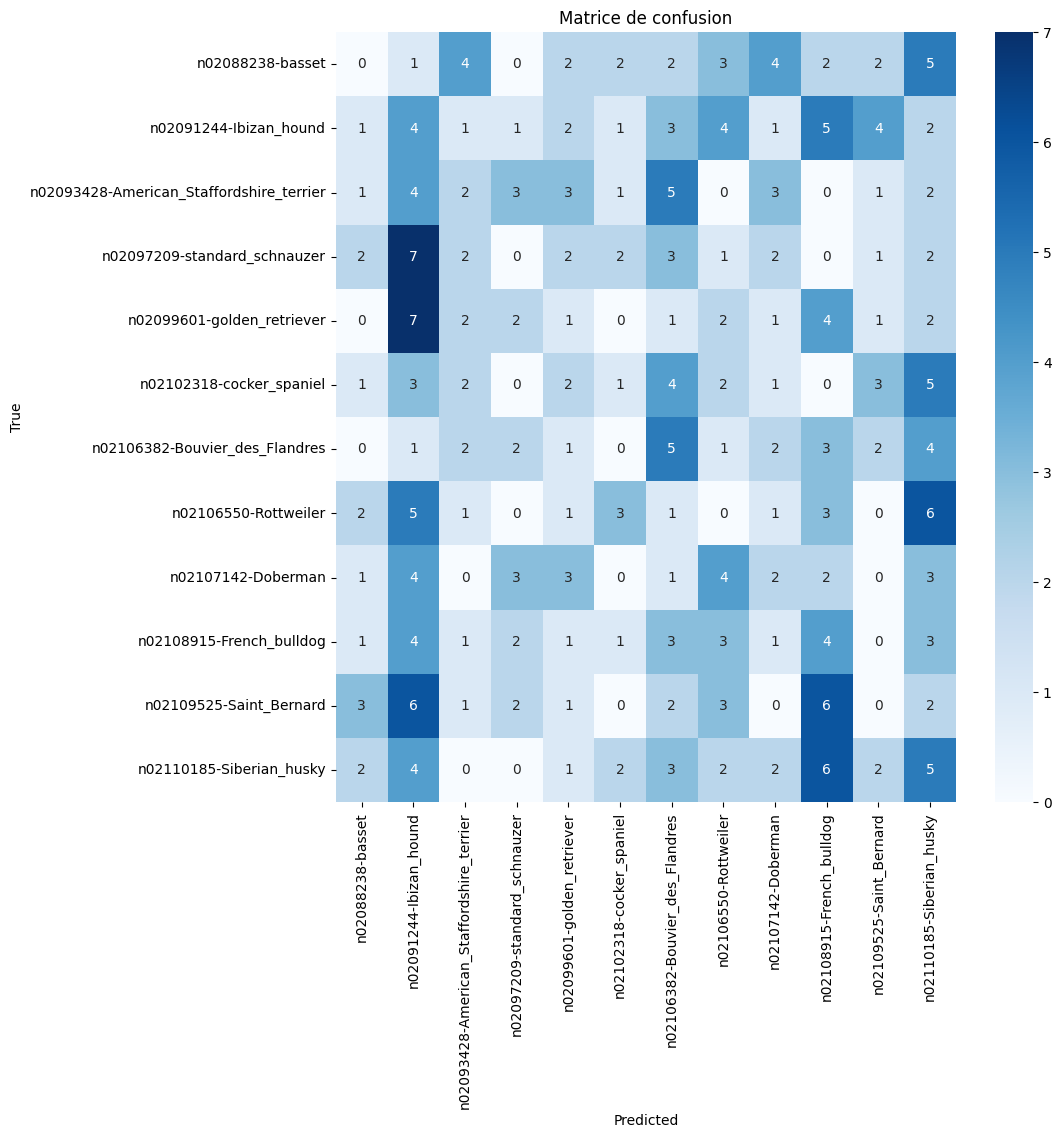

In [79]:
# Prédiction des classes pour l'ensemble de test
test_generator.reset()  # Important pour commencer à lire depuis le début
predictions = model_epoch.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

On essaie également avec un nombre d'epochs égal à 30.

In [ ]:
model_epoch30 = Sequential()

# Première couche convolutive
model_epoch30.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_epoch30.add(Activation('relu'))
model_epoch30.add(MaxPooling2D(pool_size=(2, 2)))

# Répétition du motif pour construire un modèle profond
model_epoch30.add(Conv2D(128, (3, 3)))
model_epoch30.add(Activation('relu'))
model_epoch30.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de quelques couches supplémentaires
model_epoch30.add(Conv2D(256, (3, 3)))
model_epoch30.add(Activation('relu'))
model_epoch30.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout des couches entièrement connectées
model_epoch30.add(Flatten())  # Ceci convertit les cartes de caractéristiques 3D en vecteurs 1D
model_epoch30.add(Dense(256))
model_epoch30.add(Activation('relu'))
model_epoch30.add(Dropout(0.5))
model_epoch30.add(Dense(nombre_races_chiens))
model_epoch30.add(Activation('softmax'))

# Compilation du modèle
model_epoch30.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
start_time = time.time()

model_epoch30.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")

Epoch 1/30
 6/43 [===>..........................] - ETA: 4s - loss: 4.4888 - accuracy: 0.1042

43/43 [==============================] - 7s 127ms/step - loss: 2.7755 - accuracy: 0.0905 - val_loss: 2.4823 - val_accuracy: 0.1327
Epoch 2/30
43/43 [==============================] - 6s 127ms/step - loss: 2.4684 - accuracy: 0.1139 - val_loss: 2.4565 - val_accuracy: 0.1531
Epoch 3/30
43/43 [==============================] - 5s 123ms/step - loss: 2.3179 - accuracy: 0.1942 - val_loss: 2.4274 - val_accuracy: 0.1497
Epoch 4/30
43/43 [==============================] - 5s 125ms/step - loss: 2.0635 - accuracy: 0.2942 - val_loss: 2.4561 - val_accuracy: 0.1735
Epoch 5/30
43/43 [==============================] - 5s 126ms/step - loss: 1.5272 - accuracy: 0.4964 - val_loss: 2.6798 - val_accuracy: 0.1701
Epoch 6/30
43/43 [==============================] - 5s 125ms/step - loss: 0.8337 - accuracy: 0.7241 - val_loss: 3.6174 - val_accuracy: 0.1599
Epoch 7/30
43/43 [==============================] - 5s 121ms/step - loss: 0.4068 - accuracy: 0.8745 - val_loss: 4.8405 - val_accuracy: 0.1667
Epoch 8/30
43/43 

In [ ]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_epoch = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_epoch} secondes")

Temps d'entraînement moyen : 5.402419257164001 secondes
Temps d'entraînement total : 162.07257771492004 secondes


In [ ]:
resultats = model_epoch30.evaluate(test_generator)

perte = resultats[0]
accuracy_epoch = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_epoch * 100:.2f}%")

10/10 [==============================] - 1s 53ms/step - loss: 7.3991 - accuracy: 0.1533
Accuracy sur l'ensemble de test: 15.33%


### Détection d'overfitting

`En augmentant trop le nombre d'epochs, l'accuracy de test a nettement baissé (elle passe à 15%).  
On a affaire a de l'overfitting: le modèle a surappris sur les données d'entraînement au détriment des précisions sur les données de test.`    
`On remarque par ailleurs que malgré la hausse continue de l'accuracy d'entraînement, l'accuracy connaît un point d'inflexion où elle diminue, et ce même pour un nombre d'epochs égal à 20 (où le pic est atteint à la 16e epoch avec une accuracy de validation à 0,27 et est plutôt ensuite en diminution), ce qui est également un signe de surapprentissage.`

### Modification de l'optimizer (hyperparamètre de compilation du modèle)

On remplace l'optimizer adam par l'optimizer SGD.  
SGD est une version du gradient descent où, au lieu de prendre le gradient (ou la pente) de l'ensemble des données pour mettre à jour les poids, il utilise seulement un sous-ensemble (batch) des données. Cela rend les mises à jour plus rapides et plus fréquentes.

In [80]:
from keras.optimizers import SGD
model_optimizer = Sequential()

# Première couche convolutive
model_optimizer.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3)))
model_optimizer.add(Activation('relu'))
model_optimizer.add(MaxPooling2D(pool_size=(2, 2)))

# Répétition du motif pour construire un modèle profond
model_optimizer.add(Conv2D(128, (3, 3)))
model_optimizer.add(Activation('relu'))
model_optimizer.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout de quelques couches supplémentaires
model_optimizer.add(Conv2D(256, (3, 3)))
model_optimizer.add(Activation('relu'))
model_optimizer.add(MaxPooling2D(pool_size=(2, 2)))

# Ajout des couches entièrement connectées
model_optimizer.add(Flatten())  # Ceci convertit les cartes de caractéristiques 3D en vecteurs 1D
model_optimizer.add(Dense(256))
model_optimizer.add(Activation('relu'))
model_optimizer.add(Dropout(0.5))
model_optimizer.add(Dense(nombre_races_chiens))
model_optimizer.add(Activation('softmax'))

sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9)

model_optimizer.compile(loss='categorical_crossentropy',
              optimizer=sgd_optimizer,
              metrics=['accuracy'])


In [81]:
start_time = time.time()

model_optimizer.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[time_callback])

end_time = time.time()
total_execution_time = end_time - start_time
print(f"Temps d'exécution total : {total_execution_time} secondes")

Epoch 1/10
43/43 [==============================] - 21s 437ms/step - loss: 2.4949 - accuracy: 0.0839 - val_loss: 2.4767 - val_accuracy: 0.0952
Epoch 2/10
43/43 [==============================] - 18s 418ms/step - loss: 2.4635 - accuracy: 0.1161 - val_loss: 2.4324 - val_accuracy: 0.1463
Epoch 3/10
43/43 [==============================] - 18s 418ms/step - loss: 2.3913 - accuracy: 0.1569 - val_loss: 2.3460 - val_accuracy: 0.1905
Epoch 4/10
43/43 [==============================] - 20s 456ms/step - loss: 2.3798 - accuracy: 0.1606 - val_loss: 2.3482 - val_accuracy: 0.1871
Epoch 5/10
43/43 [==============================] - 18s 414ms/step - loss: 2.3244 - accuracy: 0.1781 - val_loss: 2.2467 - val_accuracy: 0.2109
Epoch 6/10
43/43 [==============================] - 18s 422ms/step - loss: 2.2538 - accuracy: 0.1883 - val_loss: 2.2240 - val_accuracy: 0.2347
Epoch 7/10
43/43 [==============================] - 20s 466ms/step - loss: 2.2528 - accuracy: 0.2015 - val_loss: 2.2268 - val_accuracy: 0.2483

In [82]:
average_epoch_time = sum(time_callback.times) / len(time_callback.times)
time_optimizer = sum(time_callback.times)
print(f"Temps d'entraînement moyen : {average_epoch_time} secondes")
print(f"Temps d'entraînement total : {time_optimizer} secondes")

Temps d'entraînement moyen : 19.576242327690125 secondes
Temps d'entraînement total : 195.76242327690125 secondes


In [83]:
resultats = model_optimizer.evaluate(test_generator)

perte = resultats[0]
accuracy_optimizer = resultats[1]

print(f"Accuracy sur l'ensemble de test: {accuracy_optimizer * 100:.2f}%")


10/10 [==============================] - 1s 54ms/step - loss: 2.0880 - accuracy: 0.2667
Accuracy sur l'ensemble de test: 26.67%


10/10 [==============================] - 1s 56ms/step


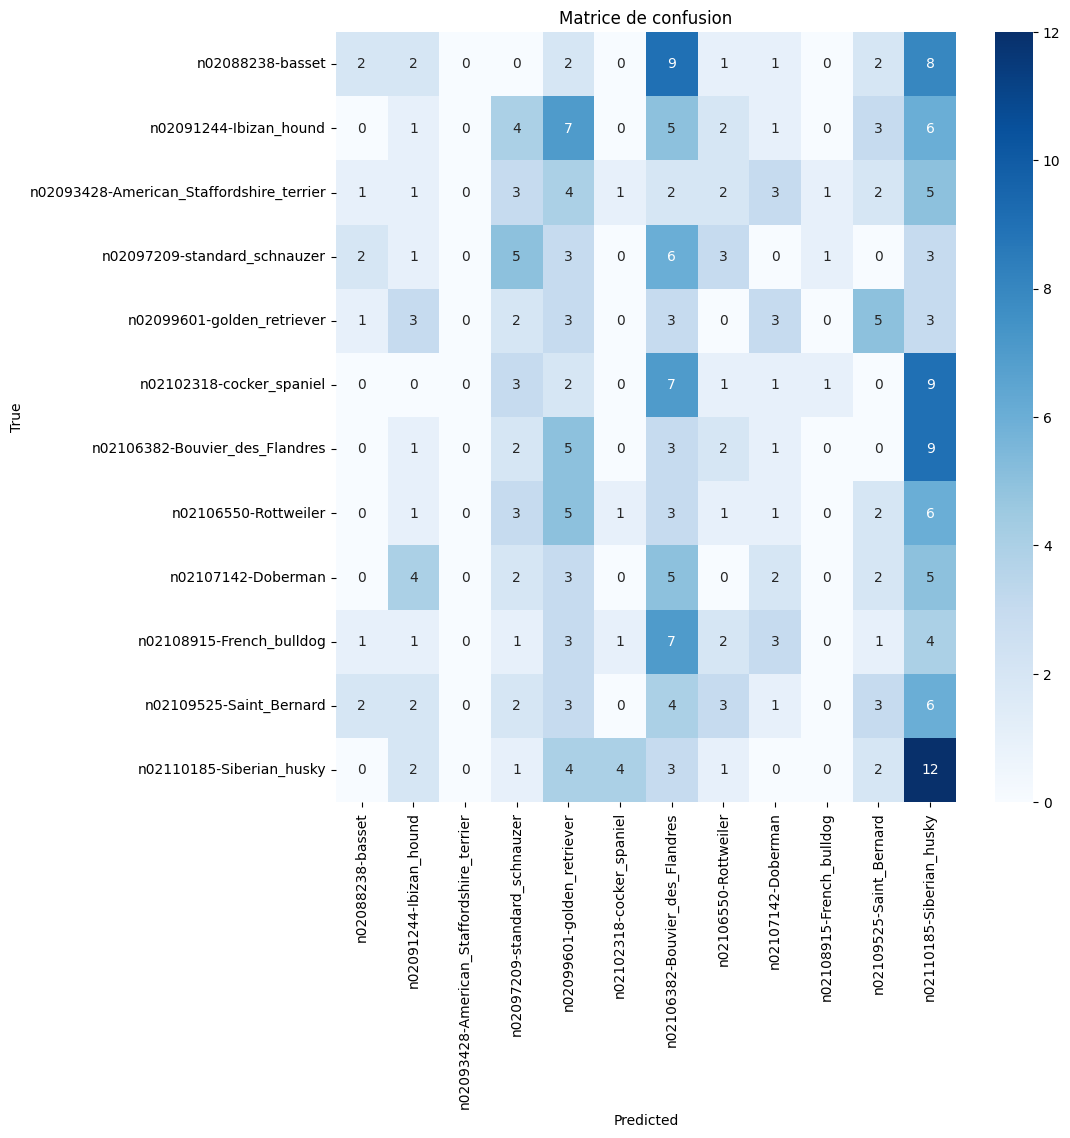

In [84]:
test_generator.reset()
predictions = model_optimizer.predict(test_generator, steps=np.ceil(test_images / batch_size))
predicted_classes = np.argmax(predictions, axis=1)

# vraies étiquettes
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matrice de confusion')
plt.show()

## Synthèse des différents temps d'entraînement et accuracy pour les modèles étudiés

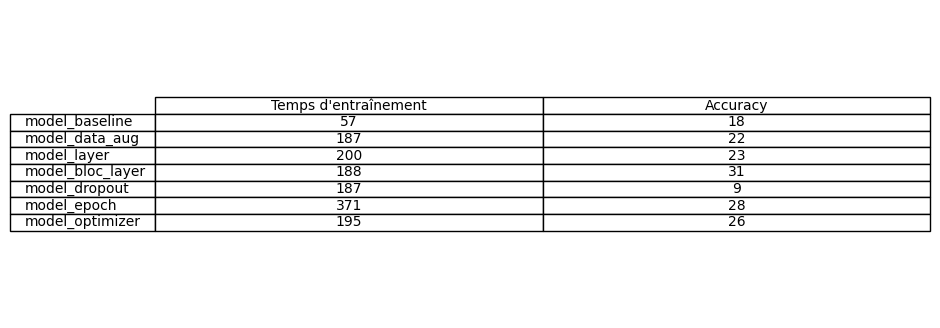

In [86]:
import pandas as pd
import matplotlib.pyplot as plt

time_variables = [time_baseline, time_data_aug, time_layer, time_bloc_layer, time_dropout, time_epoch, time_optimizer]

integer_time_variables = [int(var) for var in time_variables]

accuracy_variables = [accuracy_baseline, accuracy_data_aug, accuracy_layer, accuracy_bloc_layer, accuracy_dropout, accuracy_epoch, accuracy_optimizer]

percentage_accuracy_variables = [int(var * 100) for var in accuracy_variables]

data = {
    'Modèle': ['model_baseline', 'model_data_aug','model_layer', 'model_bloc_layer', 'model_dropout', 'model_epoch', 'model_optimizer'],
    'Temps d\'entraînement': integer_time_variables,
    'Accuracy': percentage_accuracy_variables
}

df = pd.DataFrame(data).set_index('Modèle')

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 4))  # Vous pouvez ajuster la taille comme nécessaire
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc = 'center', loc='center')

plt.show()

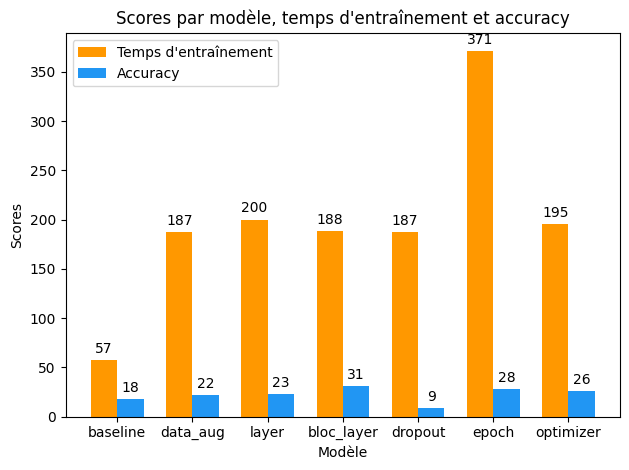

In [87]:

import matplotlib.pyplot as plt
import numpy as np

# Données d'exemple
modeles = ['baseline', 'data_aug', 'layer', 'bloc_layer', 'dropout', 'epoch', 'optimizer']
temps_entrainement = integer_time_variables
accuracy = percentage_accuracy_variables

x = np.arange(len(modeles))  # les labels des abscisses
largeur = 0.35  # la largeur des barres

fig, ax = plt.subplots()
rects1 = ax.bar(x - largeur/2, temps_entrainement, largeur, label='Temps d\'entraînement', color='#FF9800')  # Orange Material Design
rects2 = ax.bar(x + largeur/2, accuracy, largeur, label='Accuracy', color='#2196F3')  # Bleu Material Design

# Ajout de textes pour les labels, titre et légendes des axes
ax.set_xlabel('Modèle')
ax.set_ylabel('Scores')
ax.set_title('Scores par modèle, temps d\'entraînement et accuracy')
ax.set_xticks(x)
ax.set_xticklabels(modeles)
ax.legend()

# Fonction pour attacher une étiquette sur chaque barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # décalage vertical des étiquettes
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


- Le modèle le plus performant est celui où un bloc de layer a été ajouté (bloc_layer_model): pour un temps d’entraînement de 188 secondes, l’accuracy est passée de 18 (modèle baseline) à 31.   
- Le second modèle le plus performant est le modèle où l’on a doublé le nombre d’epochs (epoch_model). L’inconvénient est qu’il a un temps d’entraînement 2 fois plus élevé que les autres.  
- Le taux de dropout est plus efficace à 0,5 qu'à 0,3.  
- L'optimizer SGD avec learning_rate=0.01, momentum=0.9 est plus efficace que l'optimizer adam.